# Лабораторная работа №4. Текст

**Работа выполнена**: Бактурин Савелий Филиппович M33331

**Преподаватель**: Забашта Алексей.

## Инициализация

### Импорт библиотек

In [1]:
import pandas
import numpy
import matplotlib
import matplotlib.pyplot
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics
import sklearn.feature_extraction
import sklearn.feature_extraction.text
import copy
import itertools
import collections
import nltk
import nltk.corpus
import nltk.stem
import youtokentome
import os
import tqdm

#### Настройка библиотек

In [2]:
matplotlib.rcParams.update({'font.size': 17})

### Установка константных значений

In [3]:
from config import *

### Создание необходимых директорий

In [4]:
def mkpath(dirname, topic, name = None, ext = True):
	base_path = os.path.join(dirname, topic)
	if name:
		path = os.path.join(base_path, name.replace("/", "-"))
	else:
		return base_path
	if ext:
		return path + ".txt"
	else:
		return path

def mkpath_model(topic, name = None, ext = True):
	return mkpath(DIR_DATASET, topic, name, ext)

def mkpath_test(topic, name = None, ext = True):
	return mkpath(DIR_TESTING, topic, name, ext)

In [5]:
if not os.path.exists(DIR_DATASET):
	os.mkdir(DIR_DATASET)

if not os.path.exists(DIR_TESTING):
	os.mkdir(DIR_TESTING)

for topic in DAT_TOPICS:
	path = mkpath_model(topic)
	if not os.path.exists(path):
		os.mkdir(path)

### Загрузка данных

In [6]:
def read_topic(topic, name, mkpath):
	filename = mkpath(topic, name, False)
	with open(filename, "r") as f:
		text = f.read()
	table = { "name": name, "topic": topic, "text": text }
	return table

def read_model(topic, name):
	return read_topic(topic, name, mkpath_model)

def read_test(topic, name):
	return read_topic(topic, name, mkpath_test)

In [7]:
base_table = { "name": [], "topic": [], "text": [] }
topics = pandas.DataFrame(data = base_table)
index = 0

In [8]:
for topic in tqdm.tqdm(os.listdir(DIR_DATASET)):
	for name in tqdm.tqdm(os.listdir(mkpath_model(topic))):
		topics = pandas.concat([topics, pandas.DataFrame(data = read_model(topic, name), index = [index])])
		index += 1

100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


## Обзор данных

### Размеченные данные

In [9]:
topics.head()

,name,topic,text
0,Intercultural communication.txt,Culture,Intercultural communication is a discipline th...
1,Gen Z shake.txt,Culture,The millennial pause is a pause in speaking th...
2,Liminality.txt,Culture,"In anthropology, liminality (from Latin līmen..."
3,Communitarianism.txt,Culture,Communitarianism is a philosophy that emphasiz...
4,Human ecosystem.txt,Culture,Human ecosystems are human-dominated ecosystem...


In [10]:
topics.tail()

,name,topic,text
8063,Byron Moreno.txt,Sports,"Byron Aldemar Moreno Ruales (born November 23,..."
8064,Swingman.txt,Sports,A swingman is an athlete capable of playing mu...
8065,Tanking (sports).txt,Sports,Tanking in sports refers to the practice of in...
8066,Sport culture.txt,Sports,Sport pertains to any form of physical activit...
8067,History of ice hockey.txt,Sports,Ice hockey is believed to have evolved from si...


### Распределение количества слов в статьях

<Axes: >

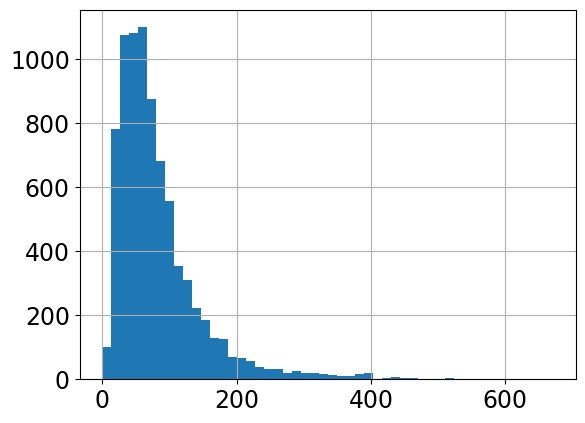

In [11]:
topics_words_n = topics.text.apply(lambda txt: len(txt.split()))
topics_words_n.hist(bins = 50)

### Словарь

In [12]:
def build_vocabulary(texts):
	words = list(itertools.chain.from_iterable([text.split() for text in texts]))
	vocab = collections.Counter(words)
	return vocab

In [13]:
texts = topics.text.tolist()
vocabulary = build_vocabulary(texts)

In [14]:
list(vocabulary.items())[:30]

[('Intercultural', 6),
 ('communication', 177),
 ('is', 14428),
 ('a', 18571),
 ('discipline', 70),
 ('that', 5823),
 ('studies', 166),
 ('across', 198),
 ('different', 660),
 ('cultures', 132),
 ('and', 21692),
 ('social', 761),
 ('groups,', 48),
 ('or', 6755),
 ('how', 331),
 ('culture', 412),
 ('affects', 32),
 ('communication.', 11),
 ('It', 2314),
 ('describes', 133),
 ('the', 33999),
 ('wide', 113),
 ('range', 200),
 ('of', 25982),
 ('processes', 142),
 ('problems', 96),
 ('naturally', 31),
 ('appear', 51),
 ('within', 508),
 ('an', 3810)]

## Предобработка данных

### Фильтрация слов

#### Очистка от специальных символов

In [15]:
def preprocess_text(text):
	text = text.lower()
	is_allowed_char = lambda c: c.isalpha() or c == ' '
	text = ''.join(list(filter(is_allowed_char, text)))
	return text

In [16]:
texts = [preprocess_text(text) for text in topics.text.tolist()]
vocabulary = build_vocabulary(texts)

In [17]:
vocabulary.most_common(30)

[('the', 40149),
 ('of', 26050),
 ('and', 21843),
 ('a', 20260),
 ('in', 17219),
 ('to', 15039),
 ('is', 14548),
 ('as', 7451),
 ('or', 7087),
 ('by', 5998),
 ('that', 5927),
 ('for', 5829),
 ('are', 4476),
 ('it', 4404),
 ('an', 4131),
 ('with', 4076),
 ('on', 3663),
 ('was', 3312),
 ('from', 3131),
 ('be', 3042),
 ('which', 2930),
 ('used', 2283),
 ('also', 2161),
 ('can', 1950),
 ('such', 1937),
 ('has', 1863),
 ('their', 1753),
 ('this', 1752),
 ('at', 1730),
 ('other', 1715)]

#### Очистка от стоп-слов

In [18]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/saveliy-
[nltk_data]     vm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
eng_stopwords = nltk.corpus.stopwords.words("english")
eng_stopwords = set(eng_stopwords)

In [20]:
def preprocess_text(txt):
	is_stopword = lambda w: w not in eng_stopwords
	txt = ' '.join(list(filter(is_stopword, txt.split())))
	return txt

In [21]:
texts = [preprocess_text(txt) for txt in texts]
vocabulary = build_vocabulary(texts)

In [22]:
vocabulary.most_common(30)

[('used', 2283),
 ('also', 2161),
 ('system', 1396),
 ('may', 1324),
 ('one', 1298),
 ('data', 1250),
 ('computer', 1124),
 ('term', 1022),
 ('information', 996),
 ('systems', 979),
 ('use', 979),
 ('known', 946),
 ('often', 908),
 ('sports', 903),
 ('first', 879),
 ('social', 868),
 ('many', 823),
 ('world', 810),
 ('two', 793),
 ('game', 788),
 ('software', 753),
 ('time', 745),
 ('human', 725),
 ('theory', 702),
 ('different', 686),
 ('called', 686),
 ('new', 678),
 ('mathematics', 669),
 ('cultural', 665),
 ('culture', 658)]

#### Лемматизация

In [23]:
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /home/saveliy-
[nltk_data]     vm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/saveliy-
[nltk_data]     vm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
eng_lemmatizer = nltk.stem.WordNetLemmatizer()
eng_stopwords = set(nltk.corpus.stopwords.words("english"))

In [25]:
def preprocess_text(txt):
	txt = ' '.join(list(map(eng_lemmatizer.lemmatize, txt.split())))
	return txt

In [26]:
texts = [preprocess_text(txt) for txt in texts]
vocabulary = build_vocabulary(texts)

In [27]:
vocabulary.most_common(30)

[('system', 2375),
 ('used', 2283),
 ('also', 2161),
 ('one', 1444),
 ('computer', 1401),
 ('game', 1333),
 ('may', 1324),
 ('sport', 1306),
 ('term', 1279),
 ('data', 1252),
 ('information', 996),
 ('use', 979),
 ('known', 946),
 ('time', 912),
 ('often', 908),
 ('human', 901),
 ('world', 886),
 ('culture', 881),
 ('first', 879),
 ('number', 874),
 ('social', 868),
 ('team', 861),
 ('form', 835),
 ('state', 834),
 ('many', 823),
 ('two', 793),
 ('theory', 792),
 ('study', 789),
 ('process', 783),
 ('group', 770)]

### Токенизация

In [28]:
with open(PTH_TOKEN_TRAIN_DATA, "w") as f_out:
	print(' '.join(topics.text), file = f_out)

In [29]:
youtokentome.BPE.train(data = PTH_TOKEN_TRAIN_DATA, model = PTH_TOKEN_MODEL, vocab_size = MDL_VOCAB_SIZE)

Training parameters
  input: articles.txt
  model: articles.pth
  vocab_size: 500000
  n_threads: 8
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 1144
number of deleted characters: 0
number of unique characters left: 1144
id: 2000=1318+11              freq: 424         subword: ants=ant+s
id: 3000=1467+1178            freq: 163         subword: ▁playing=▁play+ing
id: 4000=1260+1154            freq: 92          subword: ▁ver=▁v+er
id: 5000=1151+14              freq: 62          subword: inc=in+c
id: 6000=3362+4710            freq: 45          subword: ▁(including=▁(in+cluding
id: 7000=3739+1370            freq: 35          subword: ▁values,=▁valu+es,
id: 8000=4968+1167            freq: 28          subword: ▁assigned=▁assign+ed
id: 9000=6324+1164            freq: 23          subword: ▁minutes=▁minut+es
id: 10000=1230+1276           freq: 20          subword: ▁Sab=▁S+ab
id: 11000=1331+3489    

In [30]:
bpe = youtokentome.BPE(model = PTH_TOKEN_MODEL)

In [31]:
token_text = lambda txt: bpe.encode(txt, output_type = youtokentome.OutputType.ID)
tokens = [token_text(txt) for txt in texts]

### Итоги предобработки

In [32]:
topics["processed_text"] = texts
topics["tokens_text"] = tokens

In [33]:
topics.head()

,name,topic,text,processed_text,tokens_text
0,Intercultural communication.txt,Culture,Intercultural communication is a discipline th...,intercultural communication discipline study c...,"[13745, 2620, 4185, 1915, 2620, 2745, 1671, 16..."
1,Gen Z shake.txt,Culture,The millennial pause is a pause in speaking th...,millennial pause pause speaking present start ...,"[8357, 18384, 18384, 15810, 2421, 2330, 6274, ..."
2,Liminality.txt,Culture,"In anthropology, liminality (from Latin līmen...",anthropology liminality latin līmen threshold ...,"[2967, 96454, 1221, 2772, 121391, 11910, 4405,..."
3,Communitarianism.txt,Culture,Communitarianism is a philosophy that emphasiz...,communitarianism philosophy emphasizes connect...,"[110384, 2134, 7678, 6736, 1750, 3085, 37880, ..."
4,Human ecosystem.txt,Culture,Human ecosystems are human-dominated ecosystem...,human ecosystem humandominated ecosystem anthr...,"[1630, 3950, 3131, 1307, 17999, 3950, 86694, 5..."


In [34]:
topics.tail()

,name,topic,text,processed_text,tokens_text
8063,Byron Moreno.txt,Sports,"Byron Aldemar Moreno Ruales (born November 23,...",byron aldemar moreno ruales born november ecua...,"[1238, 1693, 1259, 16, 1234, 1181, 1305, 1541,..."
8064,Swingman.txt,Sports,A swingman is an athlete capable of playing mu...,swingman athlete capable playing multiple posi...,"[108515, 6516, 5163, 3000, 2562, 2840, 1493]"
8065,Tanking (sports).txt,Sports,Tanking in sports refers to the practice of in...,tanking sport refers practice intentionally fi...,"[34650, 1493, 2003, 2579, 16450, 38155, 1857, ..."
8066,Sport culture.txt,Sports,Sport pertains to any form of physical activit...,sport pertains form physical activity game oft...,"[1493, 15227, 1431, 2254, 3269, 1662, 1642, 48..."
8067,History of ice hockey.txt,Sports,Ice hockey is believed to have evolved from si...,ice hockey believed evolved simple stick ball ...,"[3702, 4470, 4824, 5044, 3715, 5066, 2061, 166..."


## Отчёт

### Обучение модели

#### Преобразование категорий в унитарный код

In [35]:
topics_encoded = pandas.get_dummies(topics["topic"])

In [36]:
topics_encoded.head()

,Biology,Computing,Culture,Games,Mathematics,Philosophy,Sports
0,False,False,True,False,False,False,False
1,False,False,True,False,False,False,False
2,False,False,True,False,False,False,False
3,False,False,True,False,False,False,False
4,False,False,True,False,False,False,False


In [37]:
topics_encoded.tail()

,Biology,Computing,Culture,Games,Mathematics,Philosophy,Sports
8063,False,False,False,False,False,False,True
8064,False,False,False,False,False,False,True
8065,False,False,False,False,False,False,True
8066,False,False,False,False,False,False,True
8067,False,False,False,False,False,False,True


#### Разбиение на `valid`, `test`

In [38]:
features = topics["tokens_text"]
target = copy.deepcopy(topics_encoded)

In [39]:
features_train, features_test, target_train, target_test = sklearn.model_selection.train_test_split(features, target, test_size = MDL_TEST_SIZE, random_state = 42)

#### Вспомогательные детали

##### Классификатор

In [40]:
class TextClassificator(torch.nn.Module):
	def __init__(self):
		super(TextClassificator, self).__init__()
		self.embedding = torch.nn.Embedding(MDL_VOCAB_SIZE, MDL_WORD_EMBEDDING_SIZE)
		self.lstm =  torch.nn.LSTM(MDL_WORD_EMBEDDING_SIZE, MDL_HIDDEN_SIZE, batch_first = True)
		self.linear = torch.nn.Linear(MDL_HIDDEN_SIZE, CNT_TOPICS)

	def forward(self, x):
		embedded_x = self.embedding(x)
		lstm_x, _ = self.lstm(embedded_x)
		lstm_end_state = lstm_x[:, -1, :]
		return self.linear(lstm_end_state)

##### Датасет

In [41]:
class TextStorage(torch.utils.data.Dataset):
	def __init__(self, features, target):
		self.features = features
		self.target = target

	def __len__(self):
		return len(self.features)

	def __getitem__(self, i):
		return torch.tensor(self.features.iloc[i]), torch.tensor(self.target.iloc[i])

##### Функция сбора меток

In [42]:
def get_tokens(batch):
	texts, tokens = zip(*batch)
	texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first = True, padding_value = 0)
	tokens = torch.stack(tokens)
	return texts, tokens

##### Загрузчик

In [43]:
train_storage = TextStorage(features_train, target_train)
test_storage = TextStorage(features_test, target_test)

In [44]:
train_iterator = torch.utils.data.DataLoader(
    train_storage, batch_size = MDL_BATCH_SIZE, shuffle = True, collate_fn = get_tokens
)
test_iterator = torch.utils.data.DataLoader(
    test_storage, batch_size = MDL_BATCH_SIZE, shuffle = True, collate_fn = get_tokens
)

#### Модель

In [45]:
model = TextClassificator()
criteria = MDL_CRITERIA()
optimizer = MDL_OPTIMIZER(model.parameters(), lr = MDL_LEARNING_RATE, weight_decay = 0.0001)
train_loss = []
test_loss = []
best_loss = float("inf")

/home/saveliy-vm/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
gpu_train_error = 0
gpu_test_error = 0

In [47]:
for _ in tqdm.tqdm(range(MDL_EPOCHS)):
	model.train()
	model = model.to(DEV_GPU)

	current_train_loss = 0
	current_test_loss = 0

	for w, e in train_iterator:
		try:
			optimizer.zero_grad()
			w = w.to(DEV_GPU)
			pred = model(w)
			pred = pred.to(DEV_CPU)
			loss = criteria(pred, e.float())
			loss.backward()
			optimizer.step()
			current_train_loss += loss.item()
		except Exception:
			gpu_train_error += 1

	if DEV_IS_GPU:
		torch.cuda.synchronize(DEV_GPU)

	model.eval()
	model = model.to(DEV_GPU)

	with torch.no_grad():
		for w, e in test_iterator:
			try:
				w = w.to(DEV_GPU)
				pred = model(w)
				pred = pred.to(DEV_CPU)
				loss = criteria(pred, e.float())
				current_test_loss += loss.item()
			except Exception:
				gpu_test_error += 1

	if DEV_IS_GPU:
		torch.cuda.synchronize(DEV_GPU)

	train_loss.append(current_train_loss / len(train_iterator))
	test_loss.append(current_test_loss / len(test_iterator))

	if test_loss[-1] < best_loss:
		best_loss = test_loss[-1]
		torch.save(model.state_dict(), MDL_BEST_MODEL)

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_7502/1359909344.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.features.iloc[i]), torch.tensor(self.target.iloc[i])
100%|██████████| 200/200 [1:02:51<00:00, 18.86s/it]


In [48]:
model.load_state_dict(torch.load(MDL_BEST_MODEL))

<All keys matched successfully>

In [49]:
print("GPU Train-part errors occurred:", gpu_train_error)
print("GPU Test-part errors occurred:", gpu_test_error)

GPU Train-part errors occurred: 0
GPU Test-part errors occurred: 7


In [50]:
def draw_errors(errors_train, errors_test, params):
	title = "Average error by epoch"
	xlabel = "Epoch"
	ylabel = "Error"
	matplotlib.pyplot.figure(figsize = PLT_FIGSIZE)
	matplotlib.pyplot.title(title)
	matplotlib.pyplot.plot(params, errors_train, color = CLR_TRAIN, label = "TRAIN")
	matplotlib.pyplot.plot(params, errors_test, color = CLR_TEST, label = "TEST")
	matplotlib.pyplot.xlabel(xlabel)
	matplotlib.pyplot.ylabel(ylabel)
	matplotlib.pyplot.legend()
	matplotlib.pyplot.show()

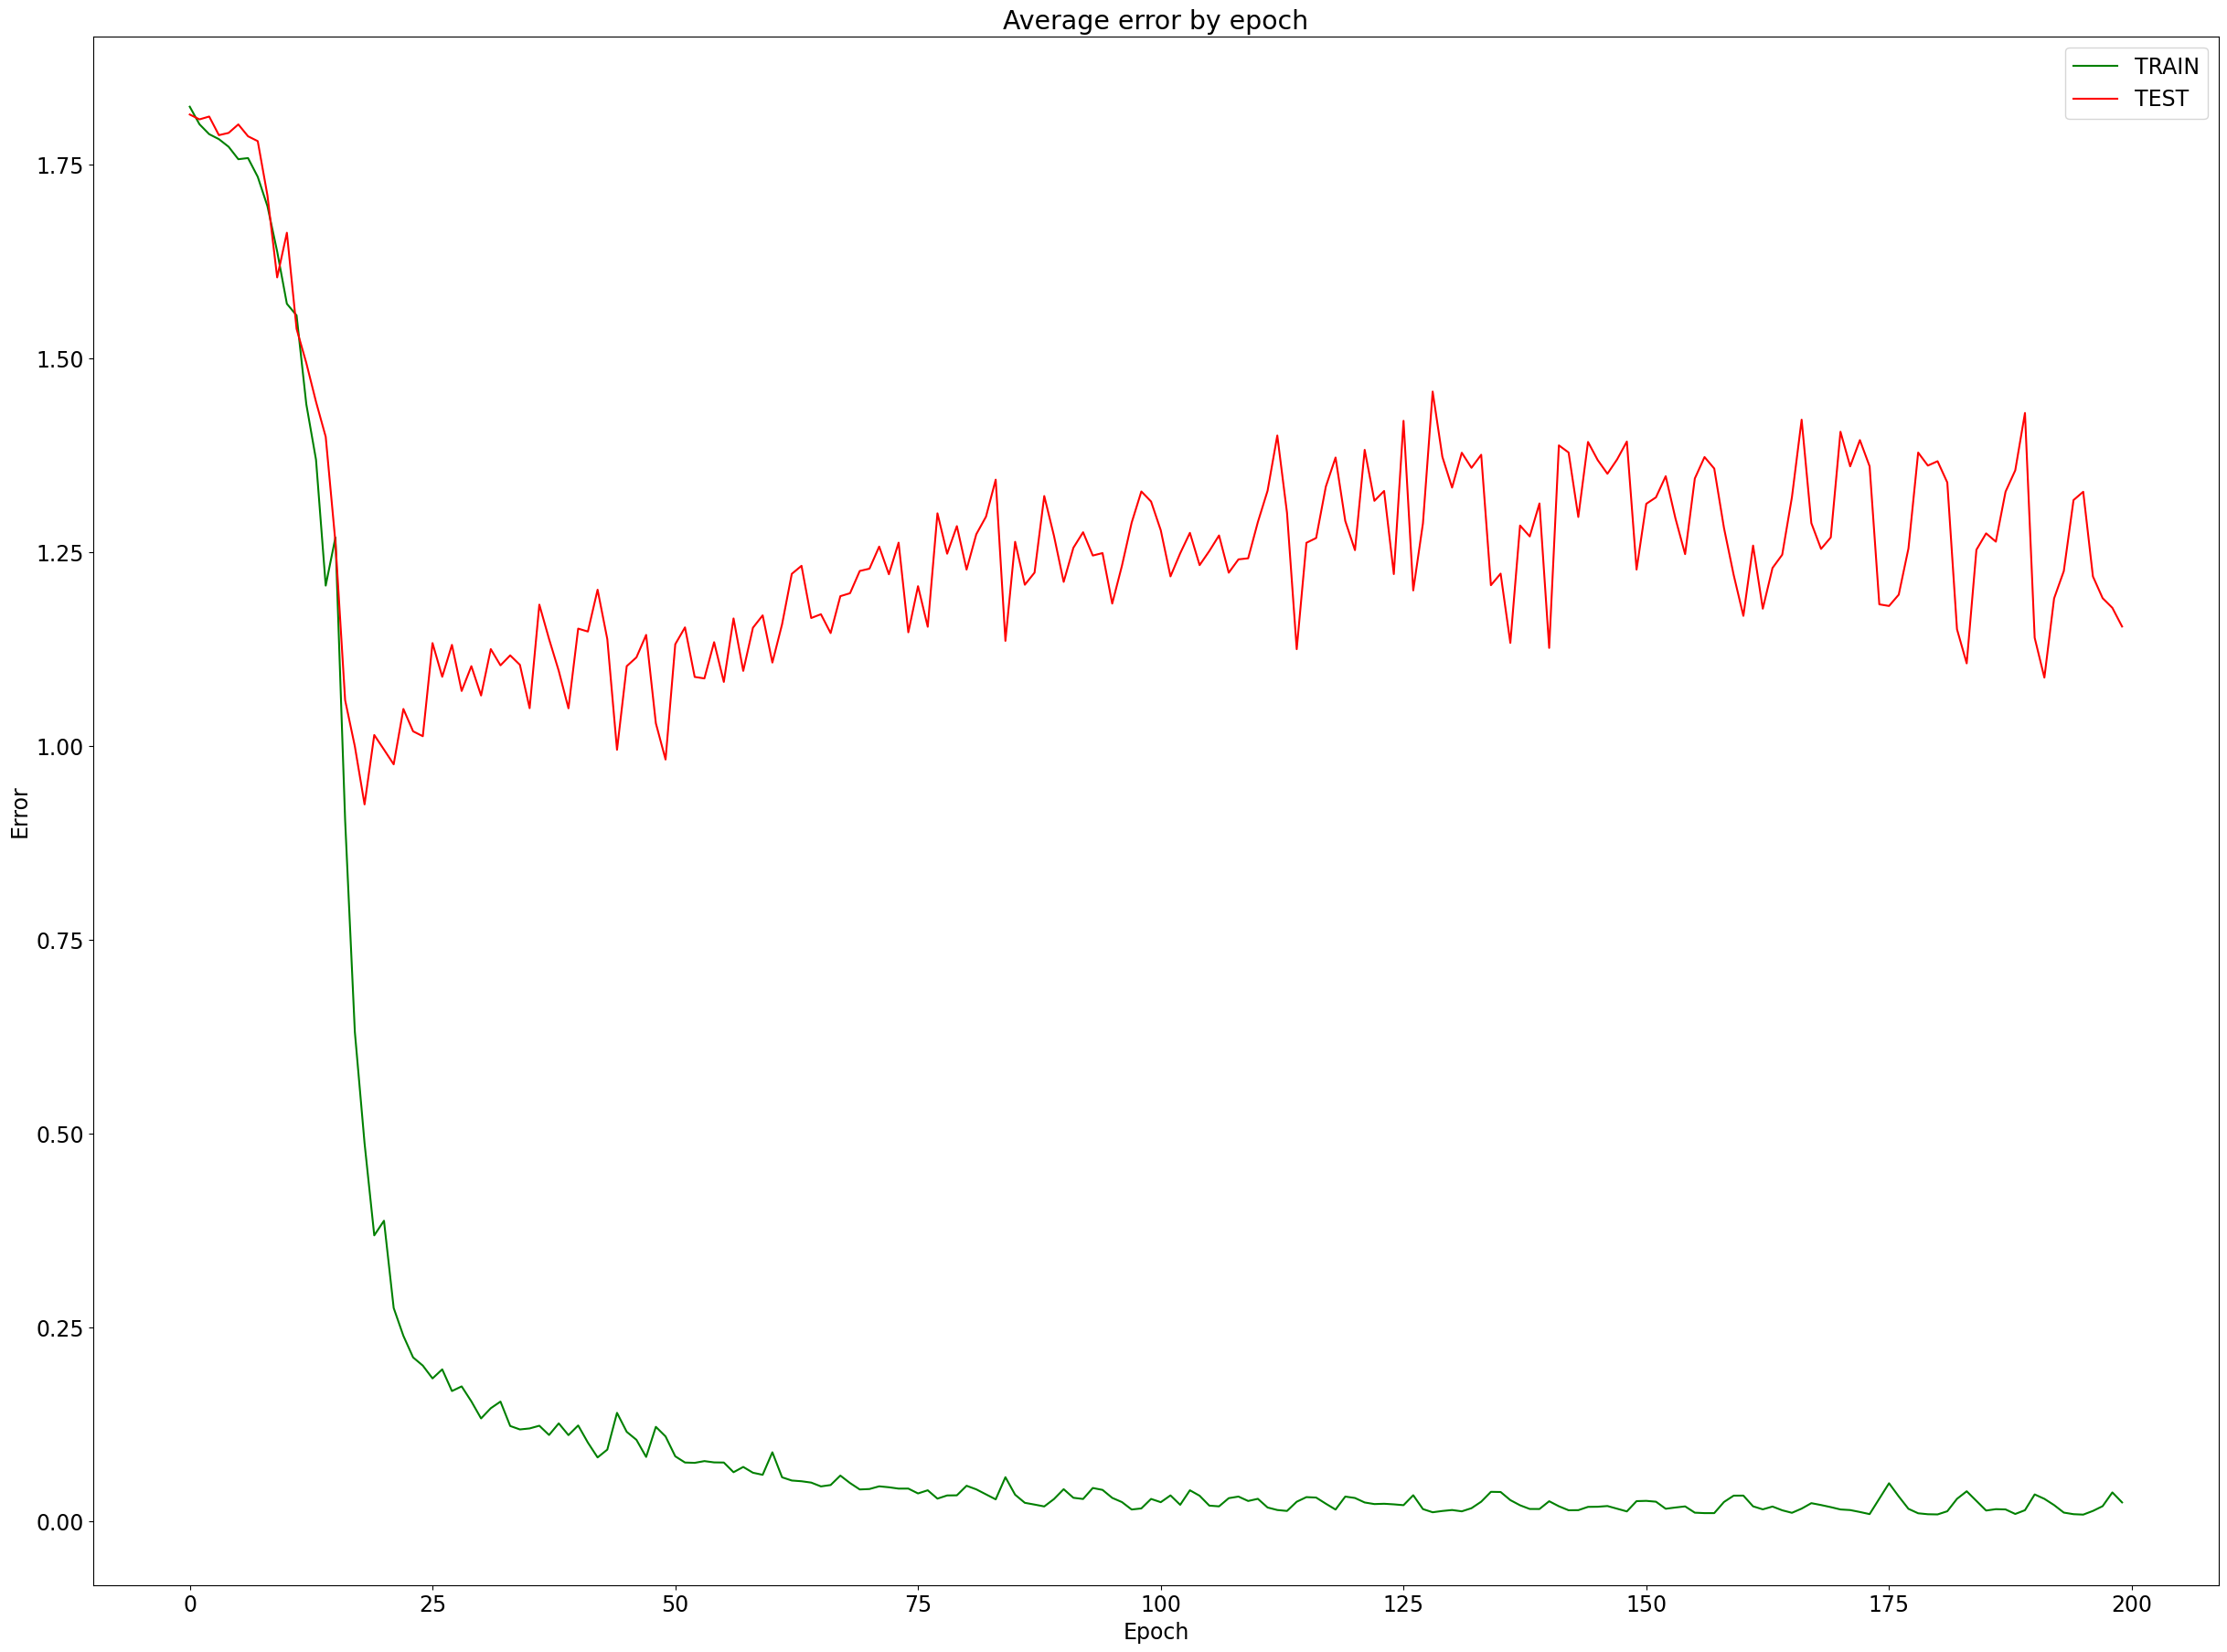

In [51]:
draw_errors(train_loss, test_loss, range(0, MDL_EPOCHS))

### Демонстрация работоспособности

In [52]:
model = model.to(DEV_CPU)
model.eval()

TextClassificator(
  (embedding): Embedding(500000, 500)
  (lstm): LSTM(500, 1000, batch_first=True)
  (linear): Linear(in_features=1000, out_features=7, bias=True)
)

In [53]:
def preprocess_text(text):
	text = text.lower()
	is_allowed_char = lambda c: c.isalpha() or c == ' '
	text = ''.join(list(filter(is_allowed_char, text)))
	is_stopword = lambda w: w not in eng_stopwords
	text = ' '.join(list(filter(is_stopword, text.split())))
	text = ' '.join(list(map(eng_lemmatizer.lemmatize, text.split())))
	return text

In [54]:
def predict(text):
	text = preprocess_text(text)
	tokens = bpe.encode(text, output_type = youtokentome.OutputType.ID)
	tokens = torch.tensor(tokens)[:500].unsqueeze(0)
	with torch.no_grad():
		pred = torch.sigmoid(model(tokens))
	pred = pred.numpy().astype(float)[0]
	return DAT_TOPICS[numpy.argmax(pred)]

In [55]:
base_table = { "name": [], "original_topic": [], "predicted_topic": [], "text": [] }
predicated = pandas.DataFrame(data = base_table)
index = 0

In [56]:
for topic in os.listdir(DIR_TESTING):
	for name in os.listdir(mkpath_test(topic)):
		read = read_test(topic, name)
		table = { "name": name, "original_topic": topic, "predicted_topic": predict(read["text"]), "text": read["text"] }
		predicated = pandas.concat([predicated, pandas.DataFrame(data = table, index = [index])])
		index += 1

In [57]:
predicated

,name,original_topic,predicted_topic,text
0,Art.txt,Culture,Culture,"Art is a diverse range of human activity, and ..."
1,Bagism.txt,Philosophy,Culture,"Bagism is a satire of prejudice, where by livi..."
2,Blue whale.txt,Biology,Biology,The blue whale (Balaenoptera musculus) is a ma...
3,End user.txt,Computing,Computing,"In product development, an end user (sometimes..."
4,Basketball (ball).txt,Games,Sports,A basketball is a spherical ball used in baske...
5,2 + 2 = 5.txt,Mathematics,Computing,2 + 2 = 5 or two plus two equals five is a mat...
6,Cooling vest.txt,Sports,Computing,A cooling vest is a piece of specially made cl...
